In [124]:
import util

import jax
import jax.numpy as np

import pandas as pd

import matplotlib.pyplot as plt

In [156]:
def get_weekly(place, start, **kwargs):
    
    prior_samples, mcmc_samples, post_pred_samples = util.load_samples(place, **kwargs)
    samples = post_pred_samples

    fields = {}
    for obs_name in ['mean_y', 'mean_z']:
        if obs_name in samples:
                obs0 = samples[obs_name + '0'][:, None]
                obs = samples[obs_name]
                obs = np.concatenate((obs0, obs), axis=1)
                if obs_name + '_future'  in samples:
                    obs_future = samples[obs_name + '_future']
                    obs = np.concatenate((obs, obs_future), axis=1)
                fields[obs_name] = obs.astype('float32')

    n_samples, T = fields['mean_z'].shape
    
    Y = fields['mean_y'].T
    Z = fields['mean_z'].T
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    weekly_confirmed = pd.DataFrame(index=t, data=Y).resample("1w").last().diff().shift(-1).iloc[:-1]
    weekly_hosp = pd.DataFrame(index=t, data=Z).resample("1w").last().diff().shift(-1).iloc[:-1]

    return weekly_confirmed, weekly_hosp

In [166]:
start = '2020-03-04'
forecast_start = '2020-04-12'

num_weeks = 25

data = util.load_state_data()
places = sorted(list(data.keys()))

for place in places:
    conf, hosp = get_weekly(place, start)
    hosp = hosp[forecast_start:].iloc[:num_weeks]
    X = hosp.values
    hosp[hosp<0.] = 0.
    print(place, "min", X.min(), "max", X.max())
    hosp.to_csv(f'hosp/{place}_hosp.csv', float_format="%.0f")

AK min 0.0 max 7951.419921875
AL min 0.0 max 118890.990234375
AR min 0.0 max 58227.9736328125
AZ min 0.0 max 170188.8046875
CA min 0.0 max 938863.4375
CO min 0.0 max 167542.98828125
CT min 0.0 max 135378.453125
DC min 0.0 max 22502.4140625
DE min 0.0 max 34603.314453125
FL min 0.0 max 643993.84375
GA min 0.0 max 401108.234375
HI min 0.0 max 14918.34326171875
IA min 0.0 max 117744.44921875
ID min 0.0 max 27665.9033203125
IL min 0.0 max 388426.2578125
IN min 0.0 max 9240.12890625
KS min 0.0 max 93026.10546875
KY min 0.0 max 173803.103515625
LA min 0.0 max 176206.90625
MA min 0.0 max 96593.611328125
MD min 0.0 max 191682.203125
ME min 0.0 max 53480.359375
MI min 0.0 max 307145.3203125
MN min 0.0 max 135081.4765625
MO min 0.0 max 352556.6953125
MS min 0.0 max 84342.1796875
MT min 0.0 max 8806.1513671875
NC min 0.0 max 271045.546875
ND min 0.0 max 14919.2939453125
NE min 0.0 max 62387.5703125
NH min 0.0 max 20413.69140625
NJ min 0.0 max 245256.84375
NM min 0.0 max 88542.0859375
NV min 0.0 m

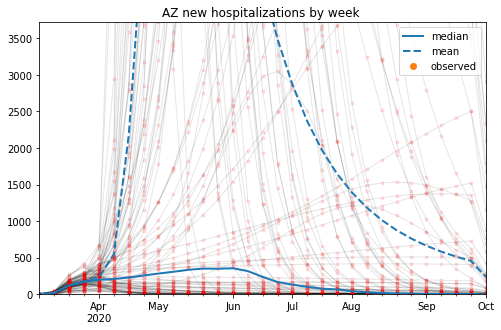

In [163]:
data = util.load_state_data()
places = sorted(list(data.keys()))
start = '2020-03-04'

#places = ['NY', 'MA', 'NJ', 'WA', 'CA']
#places = ['NY']
places = ['NY', 'MA', 'NJ', 'WA', 'AZ']

places = ['AZ']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for place in places:
    confirmed = data[place]['data'].confirmed[start:]
    hosp = data[place]['data'].hospitalizedCumulative[start:]

    weekly_confirmed, weekly_hosp = get_weekly(place, start)
    
    weekly = weekly_hosp
    
    fig, ax = plt.subplots(figsize=(8,5))
    
    weekly.plot(ax=ax, y=np.arange(100), legend=False, style='-', lw=1, color='k', alpha=0.1)
    weekly.plot(ax=ax, y=np.arange(100), legend=False, style='.', lw=1, color='r', alpha=0.1)
    weekly.median(axis=1).plot(label='median', lw=2, color=colors[0], legend=True)
    weekly.mean(axis=1).plot(label='mean', style='--', lw=2, color=colors[0], legend=True)
    
    top = weekly.quantile(0.7, axis=1).max()
    
    # show full weeks of observed data
    obs = hosp
    obs.reindex(t).resample("1w").apply(lambda x: x.iloc[-1]).diff().plot(ax=ax, 
                                                                          linestyle='None', 
                                                                          marker='o', 
                                                                          color=colors[1],
                                                                          label='observed',
                                                                          legend=True)
    
    plt.title(f'{place} new hospitalizations by week ')
    plt.ylim([0, top])
    plt.show()

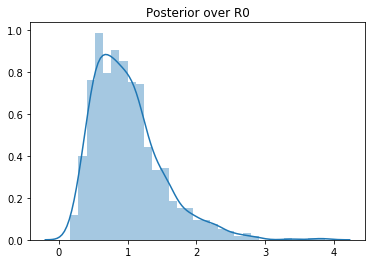

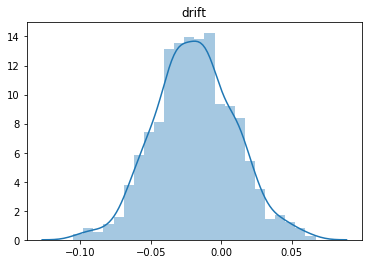

In [169]:
import seaborn as sns

place = 'NY'
prior_samples, mcmc_samples, post_pred_samples = util.load_samples(place)
beta = mcmc_samples['beta'][:,-1]
gamma = mcmc_samples['gamma']
R0 = beta/gamma
sns.distplot(R0)
plt.title('Posterior over R0')
plt.show()

sns.distplot(mcmc_samples['drift'])
plt.title('drift')
plt.show()

In [44]:
print(t)
obs = obs.reindex(t)
obs.resample("1w").last().diff()


DatetimeIndex(['2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
               '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
               '2020-03-12', '2020-03-13',
               ...
               '2020-07-08', '2020-07-09', '2020-07-10', '2020-07-11',
               '2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17'],
              dtype='datetime64[ns]', length=136, freq='D')


2020-03-08        NaN
2020-03-15      624.0
2020-03-22    14439.0
2020-03-29    44345.0
2020-04-05    62518.0
2020-04-12    27285.0
2020-04-19        NaN
2020-04-26        NaN
2020-05-03        NaN
2020-05-10        NaN
2020-05-17        NaN
2020-05-24        NaN
2020-05-31        NaN
2020-06-07        NaN
2020-06-14        NaN
2020-06-21        NaN
2020-06-28        NaN
2020-07-05        NaN
2020-07-12        NaN
2020-07-19        NaN
Freq: W-SUN, Name: confirmed, dtype: float64